# This notebook was created for `Google Colab` env, so some functions won't work on a local machine if not corrected mannualy

## Models to be fine-tuned for artworks dataset (the collections of Louvre and Art Institute of Chicago):
* [sentence-transformers/multi-qa-mpnet-base-dot-v1](https://huggingface.co/sentence-transformers/multi-qa-mpnet-base-dot-v1)
*[sentence-transformers/msmarco-bert-base-dot-v5](https://huggingface.co/sentence-transformers/msmarco-bert-base-dot-v5)

In [ ]:
# !pip install "numpy==2.0.2" "transformers==4.1.0" "sentence_transformers==4.1.0"
!pip install faiss-gpu-cu11
!pip install -U datasets


In [2]:
from google.colab import userdata
import csv
from sentence_transformers import SentenceTransformer, InputExample, models, losses, datasets
from transformers import T5Tokenizer, T5ForConditionalGeneration
from sentence_transformers.losses import TripletLoss
from torch.utils.data import DataLoader
from datasets import load_dataset, load_from_disk

import wandb
import os
import numpy as np
import math

from tqdm import tqdm
from time import time
import faiss

import matplotlib.pyplot as plt
import seaborn as sns
import torch


In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"


# Analysis of `full_info` length

In [15]:
artworks = load_dataset("anna-bozhenko/artworks", split="train")


In [ ]:
artworks_df = artworks.with_format("pandas")[:]


artworks_df["full_info_length"] = artworks_df["full_info"].apply(lambda words: len(words.split()))
# Maximum alligible length of the art-piece descriptions
max_full_info_len = np.round(artworks_df["full_info_length"].mean() + artworks_df["full_info_length"].std()).astype(int)

#extract descriptions of artworks for forming dataset of Q/A pairs
artworks_sampled = artworks_df["full_info"].dropna().sample(n=1000)
mean_arts_sample_length = int(np.mean([len(x) for x in artworks_sampled]))

# set up parameters for Q/A model to create the dataset
qa_config = {
    "batch_size": 20,               # Number of paragraphs per generation step
    "num_queries": 5,               # Number of queries to generate per paragraph
    "max_length_paragraph": mean_arts_sample_length + 1,  # Truncate/pad paragraphs
    "max_length_query": 64          # Truncate queries
}


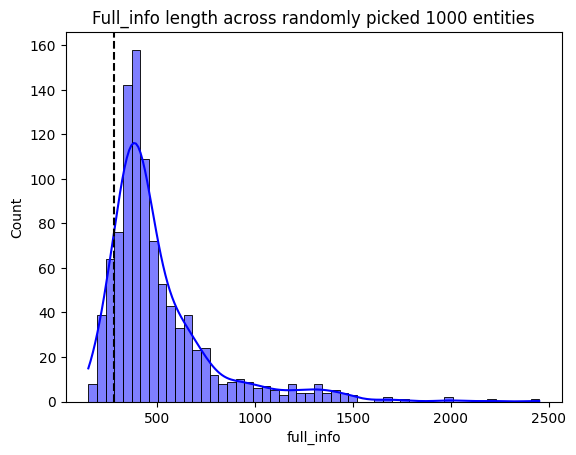

In [ ]:
std_arts_sample_length = np.std([len(x) for x in artworks_sampled])
sns.histplot(artworks_sampled.map(lambda x: len(x)), kde=True, color="b", label="desc len")
plt.axvline(x=std_arts_sample_length, color="k", linestyle="--", label="max desc len")
plt.title("Full_info length across randomly picked 1000 entities")
plt.show()


In [ ]:
max_full_info_len

np.int64(134)

# Create dataset [link text](https://) to generate positive `question-answer`  pairs (art-descriptions as answer)

In [ ]:
tokenizer = T5Tokenizer.from_pretrained("BeIR/query-gen-msmarco-t5-large-v1")
model = T5ForConditionalGeneration.from_pretrained("BeIR/query-gen-msmarco-t5-large-v1")
model.eval()

# Select the device
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)


In [ ]:
# set up directory for dataset of pairs and fine-tuned model
write_to = "/content/drive/MyDrive/artistic_styles/paintings/augmenting_model"
os.makedirs(write_to, exist_ok=True)

# set up path to the file of Q/A dataset
output_path = os.path.join(write_to, "generated_queries_all.tsv")


In [ ]:
batch_size =

In [ ]:
with open(f'{write_to}/generated_queries_all.tsv', 'w', encoding="utf-8", newline="") as f_out:
    writer = csv.writer(f_out, delimiter="\t")
    for start_idx in tqdm(range(0, len(artworks_sampled), qa_config["batch_size"])):
        sub_paragraphs = artworks_sampled[start_idx:start_idx+batch_size].tolist()
        # Tokenize input batch
        inputs = tokenizer(sub_paragraphs,
                           max_length=qa_config["max_length_paragraph"],
                           truncation=True,
                           padding=True,
                           return_tensors='pt').to(device)

        # Generate multiple queries per paragraph
        outputs = model.generate(
            **inputs,
            max_length=qa_config["max_length_query"],
            do_sample=True,
            top_p=0.95,
            num_return_sequences=qa_config["num_queries"])

        # Decode and write queries with their source paragraph
        for idx, out in enumerate(outputs):
            query = tokenizer.decode(out, skip_special_tokens=True).replace("\t", " ").strip()
            para = sub_paragraphs[idx // qa_config["num_queries"]]
            writer.writerow([query, para])


100%|██████████| 50/50 [05:21<00:00,  6.43s/it]


In [ ]:
userdata.get('WANDB_API_KEY')
wandb.login()

In [ ]:
train_examples = []


In [ ]:
write_to = "/content/drive/MyDrive/artistic_styles/paintings/augmenting_model"
input_file = f"{write_to}/generated_queries_all.tsv"

In [ ]:
with open(input_file, encoding="utf-8") as f_in:
     reader = csv.reader(f_in, delimiter="\t")
     for row in reader:
        if len(row) != 2:
            continue
        train_examples.append(InputExample(texts=row))


## Add negative pairs

In [ ]:
queries = [(i, ex.__dict__["texts"][0]) for i, ex in enumerate(train_examples)]
# add art_description's id, which correctly maprs to each question (each question has 5 identical descriptions)
queries = [(query_id, query, query_id // 5) for query_id, query in queries]

art_descriptions = np.array([ex.__dict__["texts"][1] for  ex in train_examples])
# (each question has 5 identical descriptions, so make proper indices
indices = range(0, len(art_descriptions), 5)
IDs = range(len(indices))
art_descriptions = [(_id, descr) for _id, descr in zip(IDs, art_descriptions[indices])]

In [ ]:
from sentence_transformers import SentenceTransformer

In [ ]:
model = SentenceTransformer("sentence-transformers/multi-qa-mpnet-base-dot-v1", device=device)
query_embeddings = model.encode([q for _, q, __ in queries], convert_to_numpy=True, show_progress_bar=True, device=device)
descrs_embeddings = model.encode([d for _, d in art_descriptions], convert_to_numpy=True, show_progress_bar=True, device=device)

# find the least similiar descriptions

In [ ]:
dim = len(descrs_embeddings[0])
index = faiss.IndexFlatIP(dim)
index = faiss.IndexIDMap(index)
faiss.normalize_L2(descrs_embeddings)
index.add_with_ids(np.asarray(descrs_embeddings, dtype=np.float32),
          np.arange(len(descrs_embeddings)))


In [ ]:
faiss.normalize_L2(query_embeddings)

In [ ]:
# pick top 50 non-similiar descriptions
K = 50
# negative vector (query representation) is the opposite (most far) vector, so "search for the closest vectors to the farthest vector"  == "search the least similiar vectors"
D, I = index.search(-query_embeddings, K)

# "On each positive pair make 2 negative pairs"
filtered_D = [answer_scores[-2:] for answer_scores in D]
filtered_I = [answer_indices[-2:] for answer_indices in I]


In [ ]:
queries_only = [(_id, q) for _id, q, __ in queries]

# form pairs: query_id, query, descr_id, descr
negative_trainer_dataset = [
    (query_id, q, art_descriptions[i][0], art_descriptions[i][1])
    for (query_id, q), indices in zip(queries_only, filtered_I)
    for i in indices
  ]


In [ ]:
# save negative pairs
with open(f"{write_to}/negative_artwork_qa_pairs.tsv", mode="w", encoding="utf-8", newline="") as f_out:
  writer = csv.writer(f_out, delimiter="\t")
  [writer.writerow([query_id, query, descr_id, descr]) for query_id, query, descr_id, descr in negative_trainer_dataset]


In [ ]:
positive_trainer_dataset = [
    (query_id, query, art_descr_id, art_descriptions[art_descr_id][1])
    for query_id, query, art_descr_id in queries
]

### Create positive and negative pairs

In [ ]:
negative_examples = [InputExample(texts=(q, art_descr), label=0) for q_id, q, art_descr_id, art_descr in negative_trainer_dataset]
positive_examples = [InputExample(texts=item.__dict__["texts"], label=1) for item in train_examples]
train_examples = negative_examples + positive_examples

### Create triplets: (\<query>, \<positive description>, \<negative description>)

In [ ]:
import pandas as pd

In [ ]:
positive_pairs = pd.DataFrame(positive_trainer_dataset,
                              columns = ["query_id", "query", "pos_art_descr_id", "pos_art_descr"])
negative_pairs = pd.DataFrame(negative_trainer_dataset,
                              columns = ["query_id", "query", "neg_art_descr_id", "neg_art_descr"])



In [ ]:
triplets = negative_pairs.join(positive_pairs, on="query_id", how="left", lsuffix="_neg", rsuffix="_pos")
triplet_examples = [InputExample(texts=[row["query_pos"], row["pos_art_descr"], row["neg_art_descr"]]) for _, row in triplets.iterrows()]

#Fine-tuning "sentence-transformers/multi-qa-mpnet-base-dot-v1" on triplets




In [ ]:
# model_name = "sentence-transformers/multi-qa-mpnet-base-dot-v1"
# model_name = f'{write_to}/artworks-mpnet-base-dot-v1'
# word_emb = models.Transformer(model_name)
# pooling = models.Pooling(word_emb.get_word_embedding_dimension())
# artworks_mpnet = SentenceTransformer(modules=[word_emb, pooling])


In [ ]:
## For the MultipleNegativesRankingLoss, it is important
## that the batch does not contain duplicate entries, i.e.
## no two equal queries and no two equal paragraphs.
## To ensure this, we use a special data loader
# train_dataloader = datasets.NoDuplicatesDataLoader(train_examples, batch_size=20)
## MultipleNegativesRankingLoss requires input pairs (query, relevant_passage)
## and trains the model so that is is suitable for semantic search
# train_loss = losses.MultipleNegativesRankingLoss(artworks_mpnet)


In [ ]:
# num_epochs = 5
# warmup_steps = int(len(train_dataloader) * num_epochs * 0.1)
# artworks_mpnet.fit(train_objectives=[(train_dataloader, train_loss)],
#           epochs=num_epochs,
#           warmup_steps=warmup_steps,
#           show_progress_bar=True

#       )

# model_output_dir = f'{write_to}/artworks-mpnet-base-dot-v1'
# # os.makedirs(model_output_dir, exist_ok=True)
# model.save(model_output_dir)


In [ ]:
model_name = "sentence-transformers/multi-qa-mpnet-base-dot-v1"
model_name

'sentence-transformers/multi-qa-mpnet-base-dot-v1'

In [ ]:
word_emb = models.Transformer(model_name)
pooling = models.Pooling(word_emb.get_word_embedding_dimension())
model = SentenceTransformer(modules=[word_emb, pooling])


In [ ]:
train_dataloader = DataLoader(triplet_examples, shuffle=True, batch_size=5)
train_loss = TripletLoss(model=model)

In [ ]:
# For the MultipleNegativesRankingLoss, it is important
# that the batch does not contain duplicate entries, i.e.
# no two equal queries and no two equal paragraphs.
# To ensure this, we use a special data loader
train_dataloader = datasets.NoDuplicatesDataLoader(train_examples, batch_size=50)
# MultipleNegativesRankingLoss requires input pairs (query, relevant_passage)
# and trains the model so that is is suitable for semantic search
train_loss = losses.MultipleNegativesRankingLoss(model)

In [ ]:

wandb.login()

In [ ]:
num_epochs = 10
warmup_steps = int(len(train_dataloader) * num_epochs * 0.1)
model.fit(train_objectives=[(train_dataloader, train_loss)],
          epochs=num_epochs,
          warmup_steps=warmup_steps,
          show_progress_bar=True

      )

model_output_dir = f'{write_to}/artworks-mpnet-base-dot-v1'
# os.makedirs(model_output_dir, exist_ok=True)
model.save(model_output_dir)


Step,Training Loss
500,1.885500
1000,0.620200
1500,0.428200
2000,0.376200
2500,0.218900
3000,0.207300
3500,0.196800
4000,0.149900
4500,0.084000
5000,0.071600


KeyboardInterrupt: 

In [ ]:
# test work of the model
# trained with 10_000 steps (10098 to be precise), training loss is 0.020600 on 10_000 step
model_output_dir = f'{write_to}/artworks-mpnet-base-dot-v1'
# os.makedirs(model_output_dir, exist_ok=True)
model.save(model_output_dir)

In [ ]:
artworks = load_dataset("anna-bozhenko/artworks", split="train")

# Encode artworks' descriptions with model

In [5]:
write_to = "/content/drive/MyDrive/artistic_styles/paintings/augmenting_model"

In [8]:
artworks_mpnet = SentenceTransformer(f'{write_to}/artworks-mpnet-base-dot-v1', device=device)

In [ ]:
max_words_n = 400

In [ ]:
artworks_full_info = artworks.map(lambda batch: {
    "cropped_full_info": [" ".join(x.split()[:max_words_n]) for x in batch["full_info"]]
  },
  batched=True,
  batch_size=1000
)

artworks_full_info = artworks_full_info["cropped_full_info"][:]


Map:   0%|          | 0/150780 [00:00<?, ? examples/s]

In [ ]:
encoded_data = artworks_mpnet.encode(artworks_full_info, show_progress_bar=True, device="cuda", convert_to_numpy=True)
# took 25:17 to encode

Batches:   0%|          | 0/4712 [00:00<?, ?it/s]

In [ ]:
embeddings = Dataset.from_dict({"mpnet-base-dot-v1": encoded_data})
embeddings.save_to_disk(f"{write_to}/artwork_embeddings")
# it's better to name
# ds.save_to_disk(f"{write_to}/artwork-mpnet-base-dot-v1-embeddings")

Saving the dataset (0/1 shards):   0%|          | 0/150780 [00:00<?, ? examples/s]

In [9]:
embeddings = load_from_disk(f"{write_to}/artwork_embeddings")
# embeddings = load_from_disk(f"{write_to}/artwork-mpnet-base-dot-v1-embeddings")

In [10]:
encoded_data = np.array(embeddings['mpnet-base-dot-v1'][:]).astype("float32")

In [11]:
dimension = encoded_data.shape[1]
dimension

768

In [12]:
index = faiss.IndexIDMap(faiss.IndexFlatIP(dimension))
faiss.normalize_L2(encoded_data)
index.add_with_ids(encoded_data, np.arange(encoded_data.shape[0]))
faiss.write_index(index, 'artworks_description.index')


In [ ]:
queries = [

"Paintings in the Baroque style",
"Impressionist landscape artworks",
"Renaissance portraits of noble families",
"Cubist representations of still life",
"Surrealist depictions of dreams",

"Italian art from the 15th century",
"Dutch Golden Age paintings",
"Japanese woodblock prints",
"Ancient Egyptian frescoes",
"French neoclassical sculptures",

"Works by Leonardo da Vinci",
"Paintings attributed to Claude Monet",
"Artworks created by Frida Kahlo",
"Pablo Picasso's early works"
"Rembrandt's biblical scenes",

"Portraits of a noble woman", # all are relevant
"Portraits of noble women",
"portrait of a peasant girl", # first is relevant
"Mythological scenes with Greek gods",
"Battle scenes in historical paintings",
"Religious depictions of the crucifixion",
"Artworks showing rural life",

"Paintings that evoke melancholy",
"Artworks showing joy and celebration",
"Depictions of fear and horror",
"Scenes of serenity and peace",
"Emotionally intense religious artworks",

"Oil on canvas technique",
"Watercolor landscapes",
"Fresco wall paintings",
"Engraving and etching techniques",
"Pointillist artworks",

"Marble sculptures from antiquity",
"Gold-leaf illuminated manuscripts",
"Wooden panel paintings",
"Mixed media abstract artworks",
"Terracotta figurines"
]

### evaluate model performance

In [ ]:
# test on queris
query = 'Mythological scenes with Greek gods'
query_vec = artworks_mpnet.encode([query], convert_to_numpy=True, device=device, normalize_embeddings=True).astype('float32')


D, I = index.search(query_vec, k=10)  # top-10
for i in I[0]:
    print(artworks["url"][i], artworks["full_info"][i])


https://collections.louvre.fr/ark:/53355/cl010455752 title: Allegory of victorious Greece. artist: Devéria, Achille. attribution: Deveria, Achilles, Present Attribution,. years of creation: 1800-1900
https://collections.louvre.fr/ark:/53355/cl010064487 title: Hercules in the garden of the Hesperides after fighting with the monster. artist: Anonyme. attribution: Anonyme, Present Attribution, Netherlands School, Present Attribution,. years of creation: 1750-1800. description: Trompe-l'oeil décoratif in the genre cultivated by P. J. Sauvage and wanting to evoke the great ancient sculpture so tasted at that time.. index: Mode of acquisition: assigned to the Louvre
https://collections.louvre.fr/ark:/53355/cl010061991 title: Julius II ordering the work of the Vatican and Saint Peter in Bramante, Michelangelo and Raphael. artist: Vernet, Horace. attribution: Vernet, Horace, Attribution actuelle, . École de France, Attribution actuelle,. years of creation: 1827-. index: Mode of acquisition: en

In [13]:
relevances = {'Paintings in the Baroque style': [1,1,1,1,1,0,0,1,1,1],
 'Impressionist landscape artworks': [0,0,0,0,0,0,1,0,0,0],
 'Renaissance portraits of noble families': [0,0,0,0,0,0,0,0,0,0],
 'Cubist representations of still life': [0,1,1,1,1,0,0,0,1,1],
 'Surrealist depictions': [1,1,1,1,0,0,1,1,0,0],
 'Italian art from the 15th century': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'Italian art': [0,1,1,1,0,1,1,1,0,0],
 'Dutch Golden Age paintings': [0,1,1,0,1,0,1,0,0,0],
 'Japanese woodblock prints': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'Ancient Egyptian frescoes': [0,0,1,0,0,0,0,0,0,0],
 'French neoclassical graphs': [1,0,0,0,1,1,1,0,0,0],
 "Pablo Picasso's early works": [0,0,0,0,0,0,0,0,0,0],
 'Portraits of a noble woman': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'portrait of a peasant girl': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'Mythological scenes with Greek gods': [1,1,0,0,1,1,0,1,0,0],
}

In [20]:
# set name for nn
model_name = ""
model =
save_to = "/content/drive/MyDrive/artistic_styles/paintings/augmenting_model"
queries = list(relevances.keys())
scores = list(relevances.values())

full_infos = []
urls = []
k=10

for query in queries:
  query_vec = model.encode([query], convert_to_numpy=True, device=device, normalize_embeddings=True).astype('float32')

  D, I = index.search(query_vec, k=k)
  urls.append(artworks.select(I[0])["url"])
  full_infos.append(artworks.select(I[0])["full_info"])

# set name for nn
nn_IR_df = pd.DataFrame({
    'query': [q for query in queries for q in [query] * k],
    'answer_url': [url for query_urls in urls for url in query_urls],
    'answer_text': [full_info for query_full_info in full_infos for full_info in query_full_info],
    'is_relevant_answer': np.array(list(scores)).flatten('C'),
    'rank': [r for _ in range(len(queries)) for r in range(10)]
})

nn_IR_df.to_csv(f"{save_to}/{model_name}_IR_30-05-2025.csv")


In [ ]:
def precision_at_k(results: dict, k: int) -> float:
    scores = []
    for rels in results.values():
        rels_k = rels[:k]
        precision = sum(rels_k) / len(rels_k) if rels_k else 0
        scores.append(precision)
    return np.mean(scores)

def recall_at_k(results: dict, k: int) -> float:
    scores = []
    for rels in results.values():
        total_relevant = sum(rels)
        if total_relevant == 0:
            scores.append(0.0)
        else:
            rels_k = rels[:k]
            recall = sum(rels_k) / total_relevant
            scores.append(recall)
    return np.mean(scores)

def mrr_at_k(results: dict, k: int) -> float:
    scores = []
    for rels in results.values():
        rels_k = rels[:k]
        rank = next((i + 1 for i, rel in enumerate(rels_k) if rel), 0)
        reciprocal_rank = 1 / rank if rank > 0 else 0
        scores.append(reciprocal_rank)
    return np.mean(scores)

def average_precision(rels: list, k: int) -> float:
    rels_k = rels[:k]
    ap = 0.0
    hits = 0
    for i, rel in enumerate(rels_k):
        if rel:
            hits += 1
            ap += hits / (i + 1)
    return ap / hits if hits > 0 else 0.0

def map_at_k(results: dict, k: int) -> float:
    return np.mean([average_precision(rels, k) for rels in results.values()])

def ndcg_at_k(results: dict, k: int) -> float:
    def dcg(rels: list) -> float:
        return sum(rel / math.log2(i + 2) for i, rel in enumerate(rels))

    scores = []
    for rels in results.values():
        rels_k = rels[:k]
        ideal_k = sorted(rels_k, reverse=True)
        idcg = dcg(ideal_k)
        actual_dcg = dcg(rels_k)
        ndcg = actual_dcg / idcg if idcg > 0 else 0
        scores.append(ndcg)
    return np.mean(scores)


In [ ]:
k = 10
print("Precision@K:", precision_at_k(relevances, k))
print("Recall@K:", recall_at_k(relevances, k))
print("MRR@K:", mrr_at_k(relevances, k))
print("MAP@K:", map_at_k(relevances, k))
print("NDCG@K:", ndcg_at_k(relevances, k))

Precision@K: 0.4133333333333333
Recall@K: 0.8
MRR@K: 0.5984126984126983
MAP@K: 0.5735709876543209
NDCG@K: 0.6513245401362703


In [ ]:
from time import time

# Fine-tuning "sentence-transformers/msmarco-bert-base-dot-v5" on positive, negative pairs


In [ ]:
model_name = "sentence-transformers/msmarco-bert-base-dot-v5"
# model_name = f'{write_to}/artworks-bert-base-dot-v5'
word_emb = models.Transformer(model_name)
pooling = models.Pooling(word_emb.get_word_embedding_dimension())
artworks_bert_base = SentenceTransformer(modules=[word_emb, pooling]).to("cuda")


In [ ]:
# For the MultipleNegativesRankingLoss, it is important
# that the batch does not contain duplicate entries, i.e.
# no two equal queries and no two equal paragraphs.
# To ensure this, we use a special data loader
train_dataloader = datasets.NoDuplicatesDataLoader(train_examples, batch_size=20)
# MultipleNegativesRankingLoss requires input pairs (query, relevant_passage)
# and trains the model so that is is suitable for semantic search
train_loss = losses.MultipleNegativesRankingLoss(artworks_bert_base)


In [ ]:
num_epochs = 5
warmup_steps = int(len(train_dataloader) * num_epochs * 0.1)
artworks_bert_base.fit(train_objectives=[(train_dataloader, train_loss)],
          epochs=num_epochs,
          warmup_steps=warmup_steps,
          show_progress_bar=True

      )

model_output_dir = f'{write_to}/artworks-bert-base-dot-v5'
# os.makedirs(model_output_dir, exist_ok=True)
artworks_bert_base.save(model_output_dir)
# took 1:05:04

/usr/local/lib/python3.11/dist-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by promote_options='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss
500,2.423300
1000,2.103600
1500,1.929200
2000,1.564600
2500,1.435600
3000,1.280600
3500,1.098900


### Embed and put FAISS index

In [ ]:
from datasets import load_from_disk, load_dataset, Dataset, concatenate_datasets
from sentence_transformers import SentenceTransformer, models


In [ ]:
# Envirinment specific (only applies to  author's dir)
write_to = "/content/drive/MyDrive/artistic_styles/paintings/augmenting_model"
embeddings = load_from_disk(f"{write_to}/artwork_embeddings (1)")


In [ ]:
artworks = load_dataset("anna-bozhenko/artworks", split="train")

### Encode artworks' descriptions with model

In [56]:
model_name = f'{write_to}/artworks-bert-base-dot-v5'
word_emb = models.Transformer(model_name)
pooling = models.Pooling(word_emb.get_word_embedding_dimension())
artworks_bert_base = SentenceTransformer(modules=[word_emb, pooling]).to(device)

In [ ]:
max_words_n = 400

In [ ]:
artworks_full_info = artworks.map(lambda batch: {
    "cropped_full_info": [" ".join(x.split()[:max_words_n]) for x in batch["full_info"]]
  },
  batched=True,
  batch_size=1000
)

artworks_full_info = artworks_full_info["cropped_full_info"][:]


In [ ]:
encoded_data = artworks_bert_base.encode(artworks_full_info, show_progress_bar=True, device="cuda", convert_to_numpy=True)
# took 21:59 to encode

Batches:   0%|          | 0/4712 [00:00<?, ?it/s]

In [ ]:
encoded_data.shape

(150780, 768)

In [ ]:
embeddings = load_from_disk("/content/drive/MyDrive/artistic_styles/paintings/augmenting_model/artwork_embeddings (1)")

In [ ]:
embeddings = Dataset.from_dict({"bert-base-dot-v5": encoded_data})

In [ ]:
embeddings.save_to_disk(f"{write_to}/artwork_embeddings_bert-base-dot-v5")

Saving the dataset (0/1 shards):   0%|          | 0/150780 [00:00<?, ? examples/s]

### put a faiss index and evaluate results


In [46]:
embeddings = load_from_disk(f"{write_to}/artwork_embeddings_bert-base-dot-v5")

In [47]:
encoded_data = embeddings.with_format("numpy")[:]['bert-base-dot-v5'].astype("float32")


In [50]:
dimension = encoded_data.shape[1]

In [51]:
index = faiss.IndexIDMap(faiss.IndexFlatIP(dimension))
faiss.normalize_L2(encoded_data)
index.add_with_ids(encoded_data, np.arange(encoded_data.shape[0]))
faiss.write_index(index, 'artworks_description.index')


## Evaluate IR (Information retrieval)

In [ ]:
# test on queris
query = 'Mythological scenes with Greek gods'
query_vec = artworks_bert_base.encode([query], convert_to_numpy=True, device="cuda", normalize_embeddings=True).astype('float32')

start_t = time()
D, I = index.search(query_vec, k=10)  # top-10
total_t = time() - start_t
for i in I[0]:
    print(artworks["url"][i], artworks["full_info"][i])
print(total_t)

https://www.artic.edu/artworks/114350 title: Mythological Scene. artist: Unknown artist. years of creation: 1800-1899. tags: watercolor, paper (fiber product), ink, watercolor, water-base paint, paint, gouache, graphite, drawings (visual works), prints and drawing. classification: watercolor, drawings (visual works), prints and drawing. materials: paper (fiber product), ink, watercolor, water-base paint, paint, gouache, graphite. categories: Prints and Drawings. place of origin: France. museum: The Art Institute of Chicago, location: Chicago, USA
https://www.artic.edu/artworks/114333 title: Mythological Scene. artist: Nicholas Pocock. years of creation: 1760-1821. tags: watercolor, paper (fiber product), watercolor, coating (material), graphite, drawings (visual works), prints and drawing. classification: watercolor, drawings (visual works), prints and drawing. materials: paper (fiber product), watercolor, coating (material), graphite. categories: Prints and Drawings. place of origin: 

In [57]:
relevances = {'Paintings in the Baroque style': [0,0,0,0,0,0,0,0,0, 0],
 'Impressionist landscape artworks': [1,1,0,0,1,0,0,0,0, 0],
 'Renaissance portraits of noble families': [0,1,0,0, 0, 0,0, 0,0,0],
 'Cubist representations of still life': [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
 'Surrealist depictions': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],

 'Italian art from the 15th century': [0,0,0,0,0,0,0,0,0, 0],
 'Italian art': [0,0,0,0,0,0,0,0,0, 0],
 'Dutch Golden Age paintings': [0,0,0,0,0,1,0,0,0,0],
 'Japanese woodblock prints': [1,1,1,1,0,0,1,1,0,0],
 'Ancient Egyptian frescoes': [0,0,0,0,0,0,0,0,0, 0],
 'French neoclassical graphs': [0,0,0,0,0,0,0,0,0,0],


 "Pablo Picasso's early works": [0,0,0,0,0,0,0,0,0,0],


 'Portraits of a noble woman': [1,1,1,1,0,1,1,0,0,0],

 'portrait of a peasant girl': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'Mythological scenes with Greek gods': [1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
 }

In [ ]:
# set name for nn
model_name = "bert-base-dot-v5"
model = artworks_bert_base
save_to = "/content/drive/MyDrive/artistic_styles/paintings/augmenting_model"
queries = list(relevances.keys())
scores = list(relevances.values())

full_infos = []
urls = []
k=10

for query in queries:
  query_vec = model.encode([query], convert_to_numpy=True, device=device, normalize_embeddings=True).astype('float32')

  D, I = index.search(query_vec, k=k)
  urls.append(artworks.select(I[0])["url"])
  full_infos.append(artworks.select(I[0])["full_info"])

# set name for nn
nn_IR_df = pd.DataFrame({
    'query': [q for query in queries for q in [query] * k],
    'answer_url': [url for query_urls in urls for url in query_urls],
    'answer_text': [full_info for query_full_info in full_infos for full_info in query_full_info],
    'is_relevant_answer': np.array(list(scores)).flatten('C'),
    'rank': [r for _ in range(len(queries)) for r in range(10)]
})

nn_IR_df.to_csv(f"{write_to}/{model_name}_IR_30-05-2025.csv")

In [ ]:
k = 10
print("Precision@K:", precision_at_k(relevances, k))
print("Recall@K:", recall_at_k(relevances, k))
print("MRR@K:", mrr_at_k(relevances, k))
print("MAP@K:", map_at_k(relevances, k))
print("NDCG@K:", ndcg_at_k(relevances, k))

Precision@K: 0.36666666666666675
Recall@K: 0.6
MRR@K: 0.5111111111111112
MAP@K: 0.49126690182245736
NDCG@K: 0.5255410126973494


# Evaluating  `sentence-transformers/multi-qa-MiniLM-L6-cos-v1` pretrained

In [62]:
model_name = "anna-bozhenko/artworks-search-MiniLM-L6-cos-v1"
word_emb = models.Transformer(model_name)
pooling = models.Pooling(word_emb.get_word_embedding_dimension())
artworks_minilm_cos_v1 = SentenceTransformer(modules=[word_emb, pooling]).to(device)

In [63]:
encoded_data = artworks.with_format("numpy")['embeddings'].astype(np.float32)

In [64]:
dimension = encoded_data.shape[1]

In [65]:
index = faiss.IndexIDMap(faiss.IndexFlatIP(dimension))
faiss.normalize_L2(encoded_data)
index.add_with_ids(encoded_data, np.arange(encoded_data.shape[0]))
faiss.write_index(index, 'artworks_description.index')


In [ ]:
# test on queris
query =  'Mythological scenes with Greek gods'
query_vec = artworks_minilm_cos_v1.encode([query], convert_to_numpy=True, device="cuda", normalize_embeddings=True).astype('float32')

start_t = time()
D, I = index.search(query_vec, k=10)  # top-10
total_t = time() - start_t
for i in I[0]:
    print(artworks["url"][i], artworks["full_info"][i])
print(total_t)

https://www.artic.edu/artworks/9723 title: Stater (Coin) Depicting the God Poseidon. artist: Ancient Greek. years of creation: -480--400. tags: coin, silver, gods (deities), greek, nonferrous metal, metal, inorganic material, ancient art, nudes, bull, deities, mythological figures, ancient. style title: greek. subjects: gods (deities), nudes, bull, deities, mythological figures. classification: coin, ancient art. materials: silver, nonferrous metal, metal, inorganic material. description: The front of this coin depicts the god Posidon nude, marching right and holding a trident.
On the back a bull stands facing left.
. categories: Arts of Greece, Rome, and Byzantium. place of origin: Pesto. museum: The Art Institute of Chicago, location: Chicago, USA
https://www.artic.edu/artworks/9773 title: Hemidrachm (Coin) Depicting Poseidon. artist: Ancient Greek. years of creation: -300--201. tags: coin, silver, mythological figures, greek, nonferrous metal, metal, inorganic material, ancient art,

In [66]:
relevances = {'Paintings in the Baroque style': [1,1,0,1,0,0,0,0,1,0,],
 'Impressionist landscape artworks': [0,0,0,0,0,0,0,1,1,1],
 'Renaissance portraits of noble families': [0,0,0,1,0,0,0,0,1,1],
 'Cubist representations of still life': [1,1,1,0,0,0,1,1,1,1,],
 'Surrealist depictions': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],

 'Italian art from the 15th century': [0,1,0,1,1,1,1,0,1,0],
 'Italian art': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'Dutch Golden Age paintings': [0,1,0,0,1,0,1,0,1,1,],
 'Japanese woodblock prints': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'Ancient Egyptian frescoes': [0,1,0,0,1,1,1,0,1,1,],
 'French neoclassical graphs': [0,0,1,0,0,0,0,0,1,0],


 "Pablo Picasso's early works": [0, 1, 0, 0, 0, 0, 0, 1, 0, 0],


 'Portraits of a noble woman': [1, 1, 1, 1, 1, 1, 0, 1, 1, 1],

 'portrait of a peasant girl': [1, 1, 1, 1, 0, 0, 0, 0, 1, 0],
 'Mythological scenes with Greek gods': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
 }

In [67]:
# set name for nn
model_name = "artworks-search-MiniLM-L6-cos-v1"
model = artworks_minilm_cos_v1
save_to = "/content/drive/MyDrive/artistic_styles/paintings/augmenting_model"
queries = list(relevances.keys())
scores = list(relevances.values())

full_infos = []
urls = []
k=10

for query in queries:
  query_vec = model.encode([query], convert_to_numpy=True, device=device, normalize_embeddings=True).astype('float32')

  D, I = index.search(query_vec, k=k)
  urls.append(artworks.select(I[0])["url"])
  full_infos.append(artworks.select(I[0])["full_info"])

# set name for nn
nn_IR_df = pd.DataFrame({
    'query': [q for query in queries for q in [query] * k],
    'answer_url': [url for query_urls in urls for url in query_urls],
    'answer_text': [full_info for query_full_info in full_infos for full_info in query_full_info],
    'is_relevant_answer': np.array(list(scores)).flatten('C'),
    'rank': [r for _ in range(len(queries)) for r in range(10)]
})

nn_IR_df.to_csv(f"{write_to}/{model_name}_IR_30-05-2025.csv")

In [ ]:
k = 10
print("Precision@K:", precision_at_k(relevances, k))
print("Recall@K:", recall_at_k(relevances, k))
print("MRR@K:", mrr_at_k(relevances, k))
print("MAP@K:", map_at_k(relevances, k))
print("NDCG@K:", ndcg_at_k(relevances, k))

Precision@K: 0.6133333333333333
Recall@K: 1.0
MRR@K: 0.7138888888888888
MAP@K: 0.6784489375997312
NDCG@K: 0.7917436261153064


# #TODO Fine-tuning "sentence-transformers/msmarco-distilbert-dot-v5"


In [ ]:
model_name = "sentence-transformers/msmarco-distilbert-dot-v5"
# model_name = f'{write_to}/artworks-distilbert-dot-v5'
word_emb = models.Transformer(model_name)
pooling = models.Pooling(word_emb.get_word_embedding_dimension())
artworks_distilbert = SentenceTransformer(modules=[word_emb, pooling]).to("cuda")


In [ ]:
# For the MultipleNegativesRankingLoss, it is important
# that the batch does not contain duplicate entries, i.e.
# no two equal queries and no two equal paragraphs.
# To ensure this, we use a special data loader
train_dataloader = datasets.NoDuplicatesDataLoader(train_examples, batch_size=20)
# MultipleNegativesRankingLoss requires input pairs (query, relevant_passage)
# and trains the model so that is is suitable for semantic search
train_loss = losses.MultipleNegativesRankingLoss(artworks_distilbert)


In [ ]:
num_epochs = 5
warmup_steps = int(len(train_dataloader) * num_epochs * 0.1)
artworks_distilbert.fit(train_objectives=[(train_dataloader, train_loss)],
          epochs=num_epochs,
          warmup_steps=warmup_steps,
          show_progress_bar=True

      )

model_output_dir = f'{write_to}/artworks-distilbert-dot-v5'
# os.makedirs(model_output_dir, exist_ok=True)
model.save(model_output_dir)


/usr/local/lib/python3.11/dist-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by promote_options='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss


In [ ]:
# All models to consider
model_names = ["sentence-transformers/multi-qa-mpnet-base-dot-v1",
          "sentence-transformers/msmarco-bert-base-dot-v5",
          "sentence-transformers/msmarco-distilbert-dot-v5",
          "sentence-transformers/msmarco-distilbert-base-tas-b"]


## evaluate its IR with BEIR

In [ ]:
from beir.retrieval.search.dense import DenseRetrievalExactSearch as DRES
from beir.retrieval.models import HuggingFace


In [ ]:
corpus = dict()
queries = dict()
qrels = dict()

with open(input_tsv, encoding="utf-8") as f_in:
    reader = csv.reader(f_in, delimiter="\t")

    for idx, row in enumerate(reader):
        _id = str(idx + 1)
        query = row[0].strip()
        artwork_description = row[1].strip()

        corpus[_id] = {"title": "", "text": artwork_description}
        queries[_id] = query
        qrels[_id] = {"id": 1}



# -+-+-+-

In [ ]:
model = SentenceTransformer(model_output_dir, device=device)

In [ ]:
# in order to fit the tokens vector size to the model (512 is max size), set empirically the max words N
max_words_n = 400


400

In [ ]:
artworks_full_info = artworks.map(lambda batch: {
    "cropped_full_info": [" ".join(x.split()[:max_words_n]) for x in batch["full_info"]]
  },
  batched=True,
  batch_size=1000
)

artworks_full_info = artworks_full_info["cropped_full_info"][:]


Map:   0%|          | 0/150780 [00:00<?, ? examples/s]

In [ ]:
from sklearn.preprocessing import normalize

In [ ]:
encoded_data = model.encode(artworks_full_info, show_progress_bar=True, convert_to_numpy=True)
# took 13:07 ms to encode

Batches:   0%|          | 0/4712 [00:00<?, ?it/s]

In [ ]:
faiss.normalize_L2(encoded_data)

In [ ]:
# from sklearn.preprocessing import normalize
# encoded_data = normalize(encoded_data, axis=1).astype('float32')

In [ ]:
dimension = encoded_data.shape[1]
dimension

768

In [ ]:
index = faiss.IndexIDMap(faiss.IndexFlatIP(dimension))
index.add_with_ids(encoded_data, np.arange(len(artworks_full_info)))
faiss.write_index(index, 'artworks_description.index')


In [ ]:
# check if index works

query = "portrait of a noble woman"
query_vec = model.encode([query], convert_to_numpy=True, normalize_embeddings=True).astype('float32')

D, I = index.search(query_vec, k=5)  # top-5
for i in I[0]:
    print(artworks["full_info"][i])

In [ ]:
def fetch_artpiece_info(dataframe_idx):
    info = artworks[int(dataframe_idx)]
    meta_dict = dict()
    meta_dict['title'] = info['title']
    meta_dict['artist'] = info['artist']
    meta_dict['url'] = info['url']

    return meta_dict

def search(query, top_k, index, model):
    t=time.time()
    query_vector = model.encode([query])
    top_k = index.search(query_vector, top_k)
    print('>>>> Results in Total Time: {}'.format(time.time()-t))
    top_k_ids = top_k[1].tolist()[0]
    top_k_ids = list(np.unique(top_k_ids))
    results =  [fetch_artpiece_info(idx) for idx in top_k_ids]
    return results


In [ ]:
search("Military town in Europe", 10, index, model)

### Credits for the [tutorial](https://subirverma.medium.com/semantic-search-with-s-bert-is-all-you-need-951bc710e160) of fine-tuning model

# #TODO Get IR with BEIR (needs dataset formatted specifically)

In [ ]:
!pip install beir


In [ ]:
write_to = "/content/drive/MyDrive/artistic_styles/paintings/augmenting_model"
input_tsv = f'{write_to}/generated_queries_all.tsv'

In [ ]:
import csv
import numpy as np

from sentence_transformers import SentenceTransformer

from beir import util, LoggingHandler
from beir.retrieval.evaluation import EvaluateRetrieval
from beir.retrieval.search.dense import DenseRetrievalExactSearch as DRES

import logging


In [ ]:
corpus = dict()
queries = dict()
qrels = dict()

with open(input_tsv, encoding="utf-8") as f_in:
    reader = csv.reader(f_in, delimiter="\t")

    for idx, row in enumerate(reader):
        _id = str(idx + 1)
        query = row[0].strip()
        artwork_description = row[1].strip()

        corpus[_id] = {"title": "", "text": artwork_description}
        queries[_id] = query
        qrels[_id] = {"id": 1}



In [ ]:
logging.basicConfig(
    format="%(asctime)s - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level=logging.INFO,
    handlers=[LoggingHandler()],
)


In [ ]:
class ArtworksModel:
    def __init__(self, model_path, device, **kwargs):
        self.device=device
        self.model = SentenceTransformer(model_path, device=device)

    # Write your own encoding query function (Returns: Query embeddings as numpy array)
    # For eg ==> return np.asarray(self.model.encode(queries, batch_size=batch_size, **kwargs))
    def encode_queries(self, queries: list[str], batch_size: int = 16, **kwargs) -> np.ndarray:
        return np.asarray(self.model.encode(queries,
                                            batch_size=batch_size,
                                            device=self.device,
                                            convert_to_numpy=True,
                                            **kwargs).cpu())

    # Write your own encoding corpus function (Returns: Document embeddings as numpy array)
    # For eg ==> sentences = [(doc["title"] + "  " + doc["text"]).strip() for doc in corpus]
    #        ==> return np.asarray(self.model.encode(sentences, batch_size=batch_size, **kwargs))
    def encode_corpus(self, corpus: list[dict[str, str]], batch_size: int = 8, **kwargs) -> np.ndarray:
        sentences = [doc['text'].strip() for doc in corpus]
        return np.asarray(self.model.encode(sentences,
                                            batch_size=batch_size,
                                            device=self.device,
                                            convert_to_numpy=True,
                                            **kwargs).cpu())


In [ ]:
model = DRES(ArtworksModel(model_path=f"{write_to}/artworks-search-engine-disilbert-base-uncased",
                                     device="cuda"))
retriever = EvaluateRetrieval(model, score_function="cos_sim")


In [ ]:
results = retriever.retrieve(corpus, queries)


Batches:   0%|          | 0/40 [00:00<?, ?it/s]

Batches:   0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
ndcg, _map, recall, precision = retriever.evaluate(qrels, results, retriever.k_values)


In [ ]:
k=10
print(f"ndcg@{k}: {ndcg['NDCG@10']}")
print(f"MAP@{k}: {_map['MAP@10']}")
print(f"recall@k: {recall['Recall@10']}")
print(f"precision@k: {precision['P@10']}")

ndcg@10: 0.0
MAP@10: 0.0
recall@k: 0.0
precision@k: 0.0
